### 1. Градиентный спуск

В данном разделе предстоит минимизировать функцию $$ f(x, y) = x^2 + y^2 $$ при помощи метода градиентного спуска

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import warnings

warnings.filterwarnings(action='ignore')

Задание 1. Реализуйте функцию gradient_vector таким образом, чтобы она возвращала градиент заданной функции f(x, y)

должен возвращаться numpy array, содержащий 2 numpy array (производные по x и y)

In [2]:
def gradient_vector(x: np.array, y: np.array) -> np.array:
    return np.array([2*x, 2*y])

Задание 2. Реализуйте обновление координат найденного экстремума методом градиентного спуска.

In [3]:
def gradient_descent(vector, lr=0.001, epsilon=0.001, stop_iteration=10000):
    """

    Args:
        vector (np.array): исходные занчения аргументво x, y
        lr (float, optional): learning rate. Коэффициент скорости обучения.
        epsilon (float, optional): Допустимая погрешность
        stop_iteration (int, optional): количество итераций

    Returns:
        np.array, содержащий координаты экстремума, номер итерации, градиенты x, y, значения отклонений от истинного значения
    """
    iteration = 1

    x_gradient = np.array([])
    y_gradient =  np.array([])
    loss =  np.array([])

    extremum = vector - lr * gradient_vector(vector[0], vector[1])
    x_gradient = np.append(x_gradient, extremum[0])
    y_gradient = np.append(y_gradient, extremum[1])

    while np.linalg.norm(np.subtract(extremum[0], extremum[1])) > epsilon:
        loss = np.append(loss, np.absolute(vector[0]-extremum[0]))
        vector = extremum

        extremum = vector - lr * gradient_vector(vector[0], vector[1]) 
        x_gradient = np.append(x_gradient, extremum[0])
        y_gradient = np.append(y_gradient, extremum[1])

        iteration = iteration + 1
        if iteration == stop_iteration:
            break

    return np.array([extremum, iteration, x_gradient, y_gradient, loss])

In [4]:
def plot_contour(x_gradient, y_gradient, vector):
    """
    Визуализация поиска точки экстремума
    """
    figure, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.set_theme(style='whitegrid', palette='pastel')

    contour = plt.contour(X, Y, Z, cmap=cm.RdBu)
    plt.clabel(contour, fontsize=10)

    ax.text(x=vector[0]+0.05, y=vector[1]-0.25, s='start', c='r')
    plt.plot(vector[0], vector[1], 'ro')

    ax.text(x=x_gradient[-1]+0.05, y=y_gradient[-1]-0.25, s='finish', c='b')
    plt.plot(x_gradient, y_gradient, 'bo')

    plt.show()

In [5]:
def plot_loss(loss):
    figure, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.set_theme(style='whitegrid', palette='pastel')

    ax = sns.lineplot(data=loss)
    ax.set(xlabel='Iteration')
    ax.set(ylabel='Value')
    ax.set_title('Losses')

    plt.show()

Инициализация функции для поиска точки экстремума, генерация значений функции.

$$   f(x, y) = x^2 + y^2 $$

In [6]:
def f(x, y):
    return np.power(x, 2) + np.power(y, 2)

x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

3. Воспользуйтесь полученной функцией

In [7]:
vector = np.array([2., -2.])
extremum, iteration, gdx_gradient, gdy_gradient, loss = gradient_descent(vector)

Визуализация градиентного спуска

Function extremum reached at point: (0.00050, -0.00050).
Number of iterations: 4143.


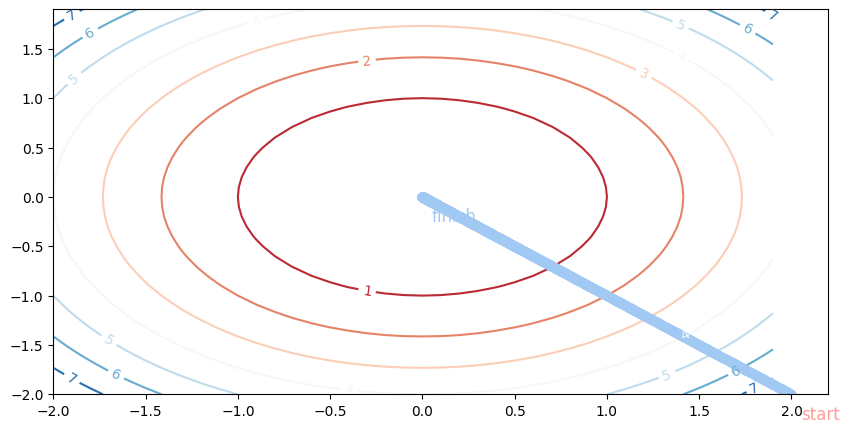

In [8]:
print('Function extremum reached at point: ({:.5f}, {:.5f}).'.format(extremum[0], extremum[1]))
print('Number of iterations: {}.'.format(iteration))

plot_contour(gdx_gradient, gdy_gradient, vector)

Визуализация функции потерь

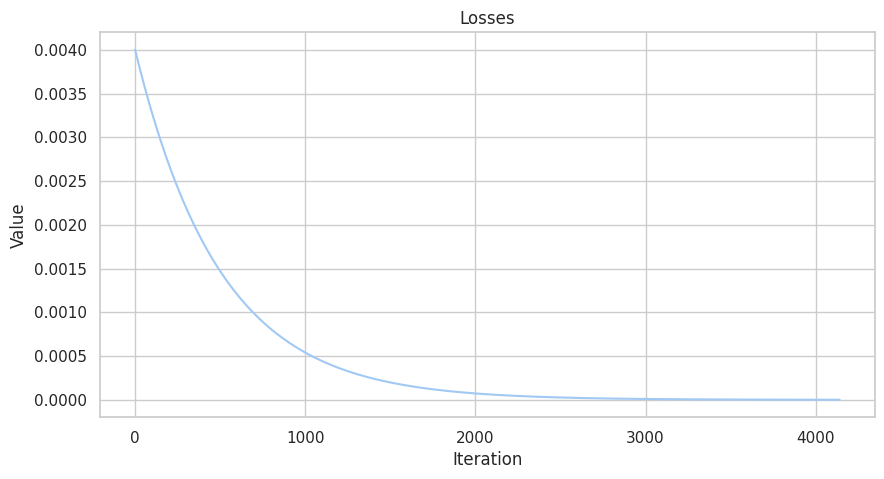

In [9]:
plot_loss(loss)

### 2. Реализация нейронной сети для решения задачи классификации

In [10]:
!wget  -O 'WineQT.csv' -q 'https://www.dropbox.com/scl/fi/qsacgxfmrio4d8crvksad/WineQT.csv?rlkey=o8mb42t8mfru5o9llgu98cxn6&dl=0'

In [11]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [12]:
df = pd.read_csv('WineQT.csv')

**Колонки**

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- **quality (Target)** : score between 0 and 10
- Id

In [13]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


Разделение на обучающую и тестовую выборки

In [14]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=1)

X_train = df_train.drop(['quality', 'Id'], axis=1)
X_val = df_val.drop(['quality', 'Id'], axis=1)

y_train = df_train['quality']
y_val = df_val['quality']

Задание 4. Примените RabustScaler для стандартизации X_train, X_val

In [15]:
scaler = RobustScaler() 
X_train = scaler.fit_transform(X_train) 
X_val = scaler.transform(X_val)

Преобразование значений к тензорам, для дальнейшей работы с pyTorch

In [16]:
X_train_ts = torch.FloatTensor(X_train)
X_val_ts = torch.FloatTensor(X_val)

y_train_ts = torch.LongTensor(y_train.values)
y_val_ts = torch.LongTensor(y_val.values)

In [17]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()

        self.fc1 = nn.Linear(X_train_ts.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 11)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.relu(x)

        output = self.fc4(x)
        return output

In [18]:
model = DNN()

loss_fn = nn.CrossEntropyLoss()

Задание 5. Заполните пропуски функции train_model

1) Инициализируйте оптимизатор ADAM.

2) Воспользуйтесь методом zero_grad

3) Вычислите градиенты функции потерь по параметрам модели, используя метод обратного распространения ошибки. backward

4) Обновите значения оптимизатора. step

In [19]:
def train_model(model, lr=1e-3, n_epoch=500):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    train_scores = []
    val_scores = []

    for epoch in range(1, n_epoch+1):
        model.train()
        out = model(X_train_ts)
        loss = loss_fn(out, y_train_ts)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (torch.argmax(out, dim=1) == y_train_ts).float().mean().item()

        model.eval()
        with torch.no_grad():
            out_val = model(X_val_ts)
            loss_val = loss_fn(out_val, y_val_ts)
            acc_val = (torch.argmax(out_val, dim=1) == y_val_ts).float().mean().item()

            train_losses.append(loss.item())
            val_losses.append(loss_val.item())

            train_scores.append(acc)
            val_scores.append(acc_val)

        if epoch % 20 == 0:
            print('Epoch : {:3d} / {}, Loss : {:.4f}, Accuracy : {:.2f} %, Val Loss : {:.4f}, Val Accuracy : {:.2f} %'.format(
                epoch, n_epoch, loss.item(), acc*100, loss_val.item(), acc_val*100))

    plt.plot(train_scores)
    plt.plot(val_scores)
    plt.legend(["train","test"])
    return train_losses, val_losses, train_losses, val_scores

Epoch :  20 / 700, Loss : 1.7806, Accuracy : 53.28 %, Val Loss : 1.7542, Val Accuracy : 52.40 %
Epoch :  40 / 700, Loss : 1.1848, Accuracy : 55.80 %, Val Loss : 1.1646, Val Accuracy : 56.77 %
Epoch :  60 / 700, Loss : 1.0498, Accuracy : 58.42 %, Val Loss : 1.0528, Val Accuracy : 59.83 %
Epoch :  80 / 700, Loss : 0.9782, Accuracy : 60.83 %, Val Loss : 0.9880, Val Accuracy : 59.83 %
Epoch : 100 / 700, Loss : 0.9250, Accuracy : 62.80 %, Val Loss : 0.9508, Val Accuracy : 59.39 %
Epoch : 120 / 700, Loss : 0.8797, Accuracy : 64.55 %, Val Loss : 0.9238, Val Accuracy : 61.57 %
Epoch : 140 / 700, Loss : 0.8398, Accuracy : 66.08 %, Val Loss : 0.9129, Val Accuracy : 63.32 %
Epoch : 160 / 700, Loss : 0.8000, Accuracy : 68.38 %, Val Loss : 0.9106, Val Accuracy : 62.45 %
Epoch : 180 / 700, Loss : 0.7585, Accuracy : 69.04 %, Val Loss : 0.9196, Val Accuracy : 60.70 %
Epoch : 200 / 700, Loss : 0.7146, Accuracy : 71.55 %, Val Loss : 0.9344, Val Accuracy : 60.70 %
Epoch : 220 / 700, Loss : 0.6652, Accura

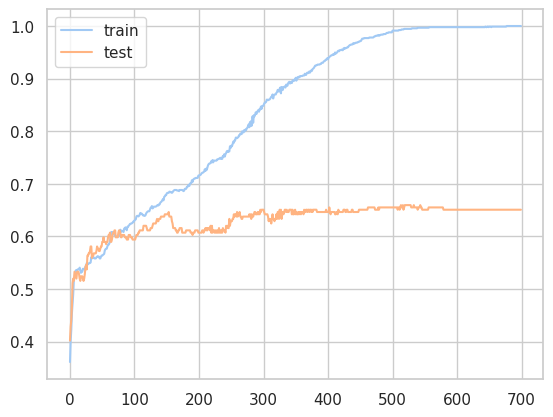

In [20]:
train_model(model, n_epoch=700);

Можно наблюдать переобучение, так как при росте точности на обучающей выборке, на валидационной ее значение начало снижаться

Задание 6. Проверьте различные конфигурации (число слоев, их размер) модели DNN.

Можете также опробовать различное число эпох и значения learning_rate при обучении.

Требуется найти такую конфигурацию, при которой переобучения не будет

In [40]:
class BetterDNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
                nn.Linear(X_train_ts.shape[1], 128),
                # nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Linear(128, 64),
                # nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Linear(32, 11)
        )

    def forward(self, x):
        return self.layers(x)

Epoch :  20 / 700, Loss : 1.6044, Accuracy : 61.82 %, Val Loss : 2.0339, Val Accuracy : 51.53 %
Epoch :  40 / 700, Loss : 1.2442, Accuracy : 67.83 %, Val Loss : 1.4085, Val Accuracy : 62.01 %
Epoch :  60 / 700, Loss : 0.9937, Accuracy : 72.21 %, Val Loss : 1.1956, Val Accuracy : 61.57 %
Epoch :  80 / 700, Loss : 0.7930, Accuracy : 77.35 %, Val Loss : 1.1345, Val Accuracy : 62.88 %
Epoch : 100 / 700, Loss : 0.6214, Accuracy : 83.48 %, Val Loss : 1.0984, Val Accuracy : 63.32 %
Epoch : 120 / 700, Loss : 0.4780, Accuracy : 88.07 %, Val Loss : 1.0979, Val Accuracy : 64.19 %
Epoch : 140 / 700, Loss : 0.3653, Accuracy : 91.25 %, Val Loss : 1.1438, Val Accuracy : 65.50 %
Epoch : 160 / 700, Loss : 0.2692, Accuracy : 94.97 %, Val Loss : 1.2071, Val Accuracy : 65.50 %
Epoch : 180 / 700, Loss : 0.1965, Accuracy : 97.05 %, Val Loss : 1.2595, Val Accuracy : 65.94 %
Epoch : 200 / 700, Loss : 0.1425, Accuracy : 98.80 %, Val Loss : 1.3491, Val Accuracy : 67.25 %
Epoch : 220 / 700, Loss : 0.1041, Accura

([2.347203493118286,
  2.263023614883423,
  2.197493553161621,
  2.140939474105835,
  2.090308904647827,
  2.0434255599975586,
  1.9994791746139526,
  1.9591031074523926,
  1.9207966327667236,
  1.8847147226333618,
  1.8512327671051025,
  1.8193045854568481,
  1.7888504266738892,
  1.7598031759262085,
  1.73202645778656,
  1.705029010772705,
  1.6788183450698853,
  1.653262972831726,
  1.628477692604065,
  1.604373812675476,
  1.5810039043426514,
  1.5584614276885986,
  1.5368138551712036,
  1.5158566236495972,
  1.4955036640167236,
  1.475834608078003,
  1.456602692604065,
  1.4380619525909424,
  1.4200602769851685,
  1.402425765991211,
  1.3852003812789917,
  1.3684133291244507,
  1.3516725301742554,
  1.3352750539779663,
  1.3194056749343872,
  1.3038896322250366,
  1.2885379791259766,
  1.2735000848770142,
  1.258687973022461,
  1.2442207336425781,
  1.2299410104751587,
  1.2157951593399048,
  1.2020378112792969,
  1.188494324684143,
  1.1751333475112915,
  1.161948800086975,
  1.1

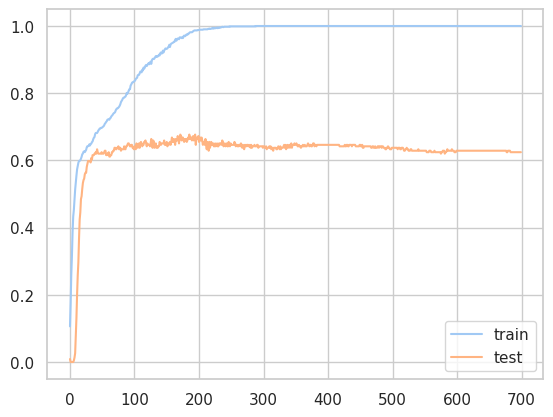

In [42]:
better_model = BetterDNN()

train_model(better_model, lr=1e-3, n_epoch=700)